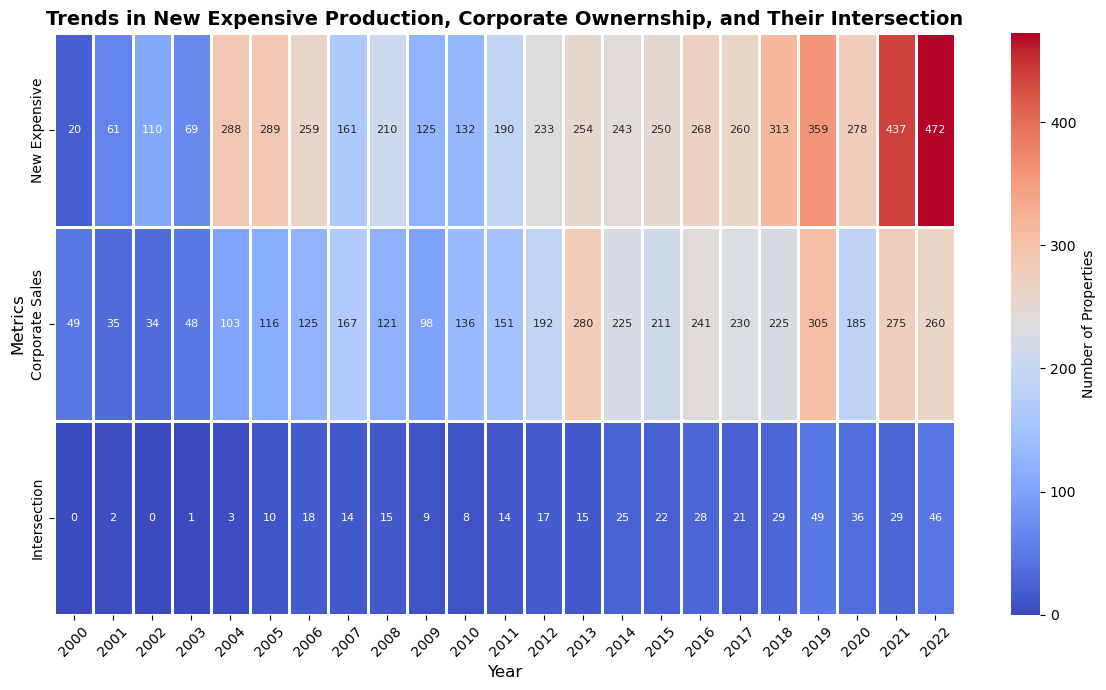

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data (adjust the path as needed)
Residential_data = pd.read_csv('Data/Residential sales data in the City of Boston, 2000-2023/A2_EDA_Residential.csv')

# Convert date to datetime and create a year column if it doesn't exist
Residential_data['date'] = pd.to_datetime(Residential_data['date'])
if 'year' not in Residential_data.columns:
    Residential_data['year'] = Residential_data['date'].dt.year

# For this example, assume the dataset is already for Boston.
boston_data = Residential_data

# Identify properties that are “new and expensive high-rises”
new_expensive = boston_data[(boston_data['yearbuilt'] >= 2000) & 
                            (boston_data['price'] >= boston_data['price'].quantile(0.50))]

# Identify transactions indicative of absentee ownership
absentee_sales = boston_data[boston_data['buyer_llc_ind'] == 1]

# Identify properties that are both new, expensive, and absentee owned
new_expensive_absentee = new_expensive[new_expensive['buyer_llc_ind'] == 1]

# Group data by year
production_counts = new_expensive.groupby('year').size()
absentee_counts = absentee_sales.groupby('year').size()
intersection_counts = new_expensive_absentee.groupby('year').size()

# Ensure the index (years) covers the full range
all_years = list(set(production_counts.index) | set(absentee_counts.index) | set(intersection_counts.index))
all_years.sort()

# Reindex the series, filling missing years with a count of 0
production_counts = production_counts.reindex(all_years, fill_value=0)
absentee_counts = absentee_counts.reindex(all_years, fill_value=0)
intersection_counts = intersection_counts.reindex(all_years, fill_value=0)

# Create a DataFrame for easy plotting
heatmap_data = pd.DataFrame({
    'New Expensive': production_counts.values,
    'Corporate Sales': absentee_counts.values,
    'Intersection': intersection_counts.values
}, index=all_years)

# Plot heatmap with smaller text sizes
plt.figure(figsize=(12, 7))
sns.heatmap(
    heatmap_data.T, 
    annot=True, 
    fmt="d", 
    cmap="coolwarm", 
    cbar_kws={'label': 'Number of Properties'},
    linewidths=1, 
    linecolor='white',
    annot_kws={'size': 8}  # smaller annotation font size
)
plt.title("Trends in New Expensive Production, Corporate Ownernship, and Their Intersection", fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Metrics", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
# Save the plot
plt.savefig('boston_trends_heatmap.png')  # Save the plot as an image file
plt.show()




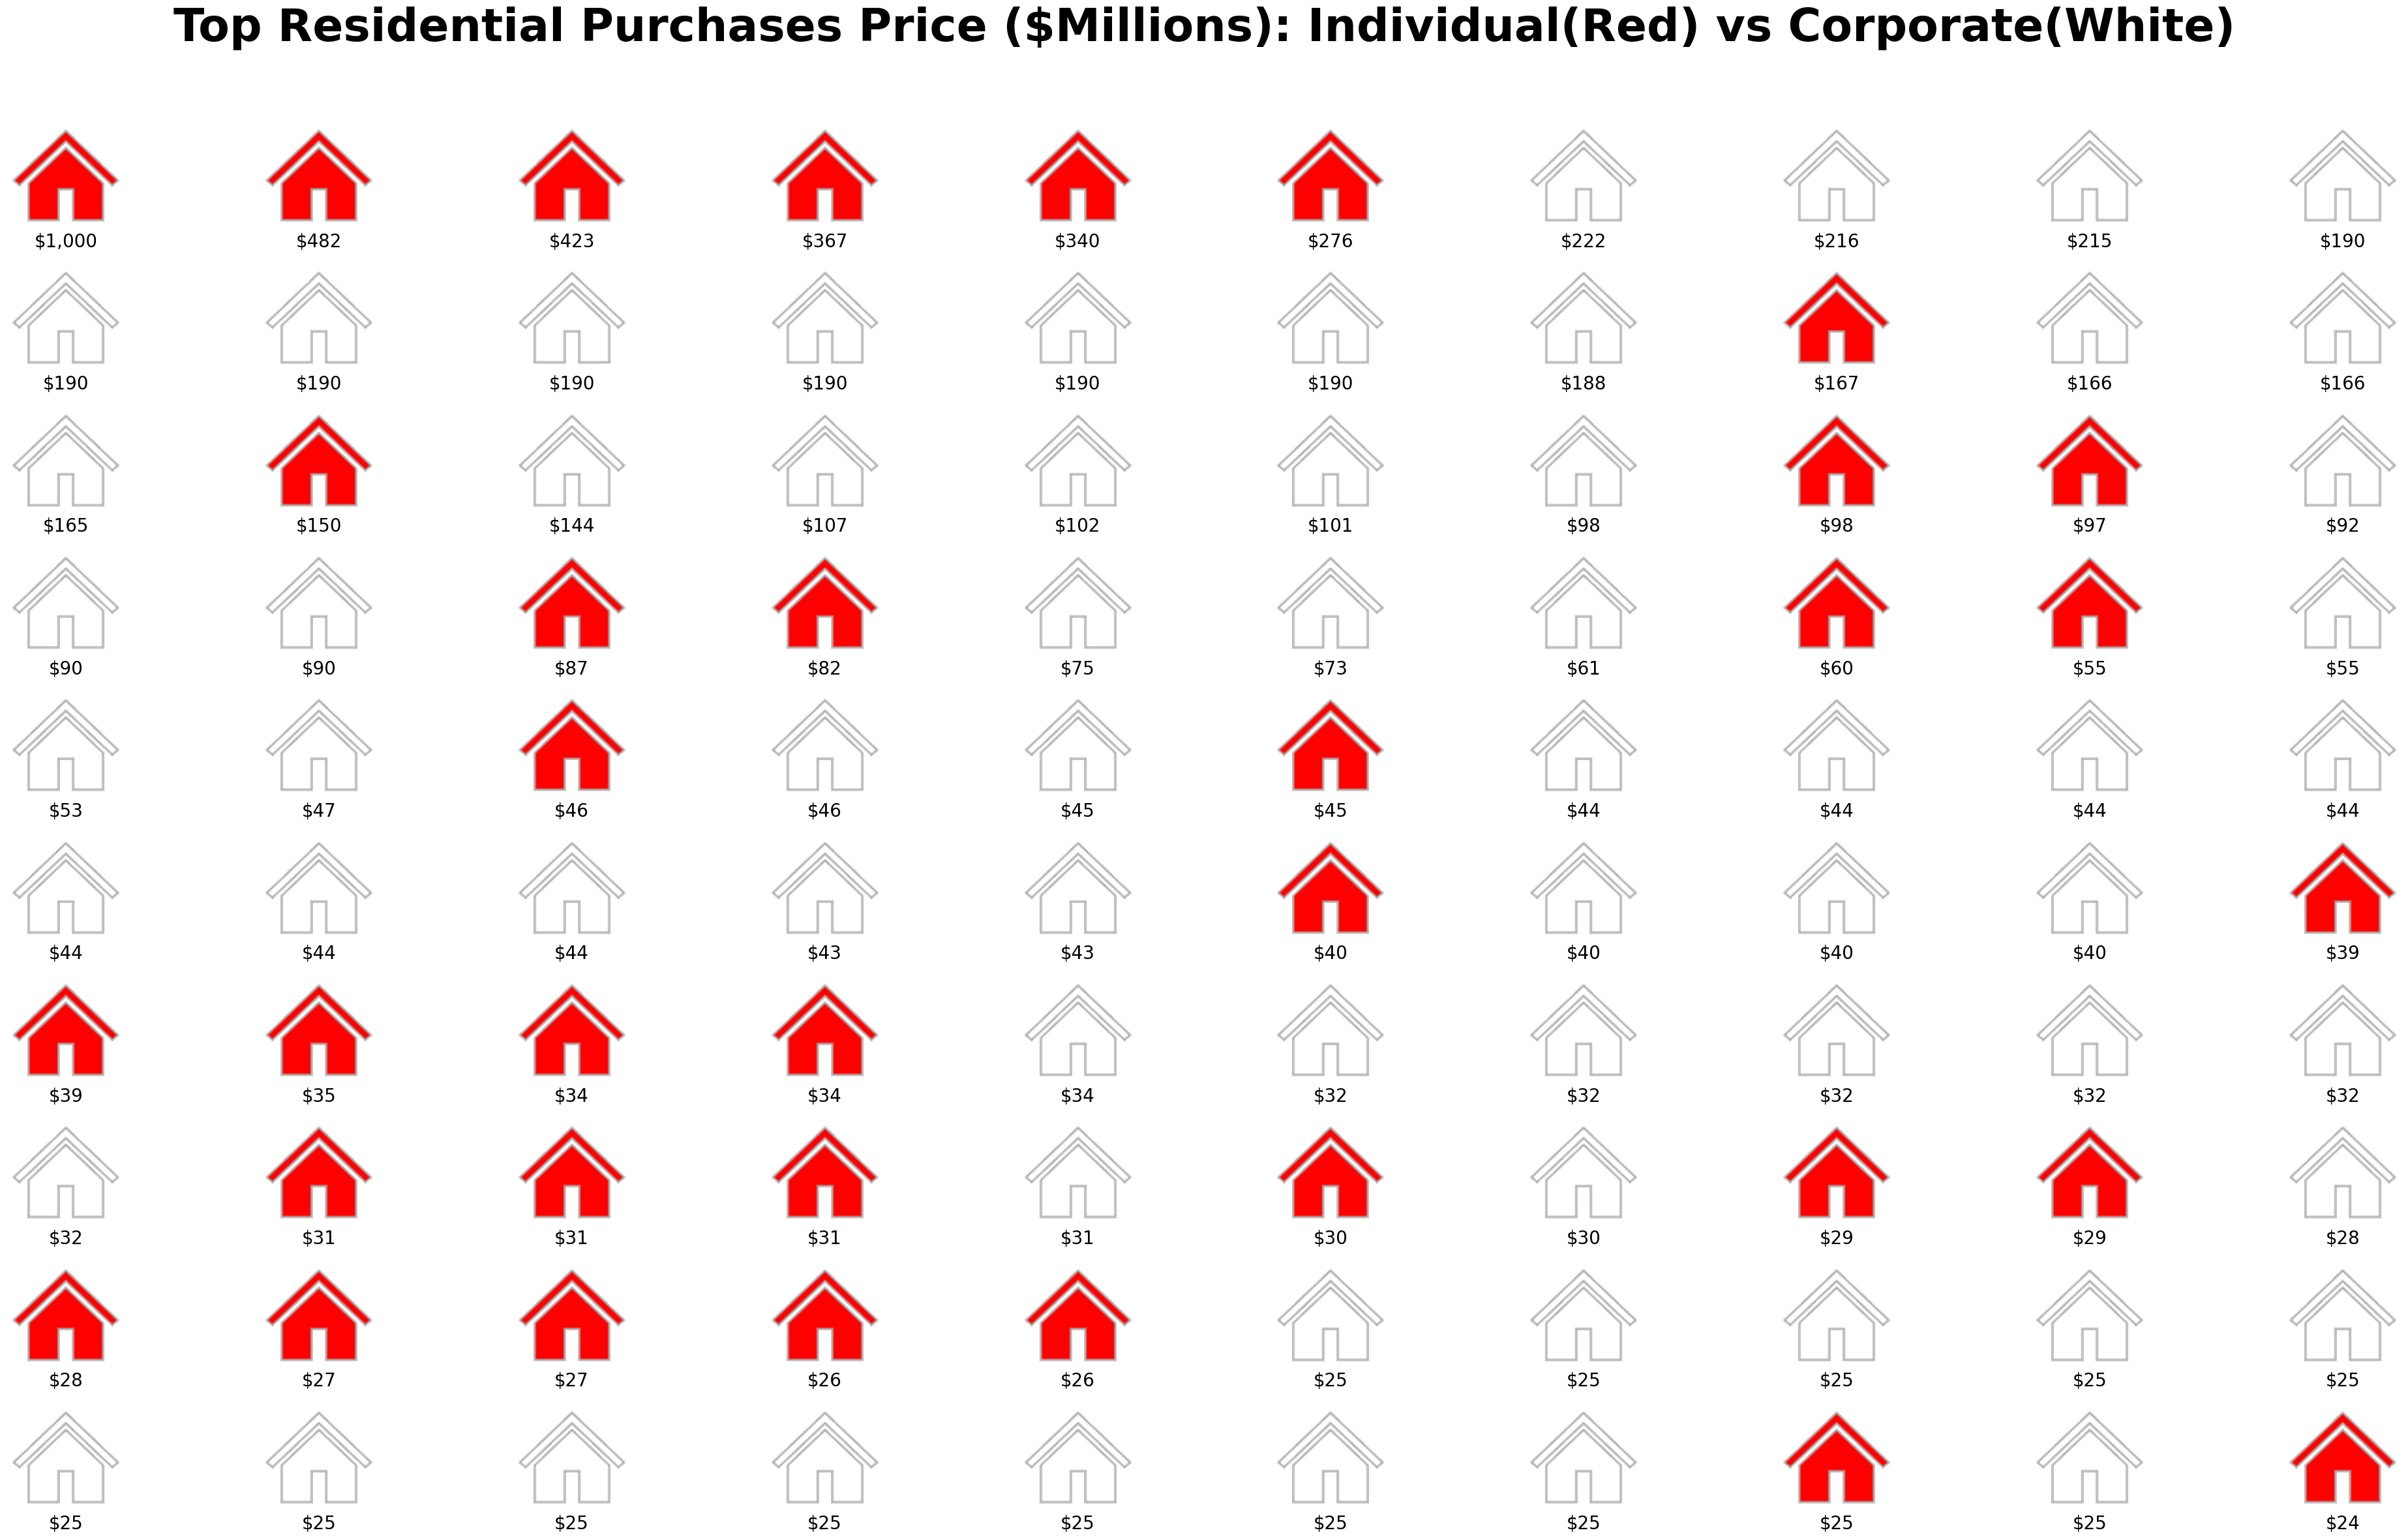

Percentage of corporate buyers among the top 100 houses: 63.00%


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math

# -----------------------------
# 1. Load and prepare the data
# -----------------------------
data_path = 'Data/Residential sales data in the City of Boston, 2000-2023/A2_EDA_Residential.csv'
data = pd.read_csv(data_path)

# Convert the date column to datetime and create a year column if needed
data['date'] = pd.to_datetime(data['date'])
if 'year' not in data.columns:
    data['year'] = data['date'].dt.year

# -----------------------------
# 2. Select the top houses
# -----------------------------
num_houses = 100  # Adjust as needed

# Sort by price in descending order and take the top houses excluding proptype == COM
top_houses = data[data['proptype'] != 'COM'].sort_values('price', ascending=False).head(num_houses)

# -----------------------------
# 3. Define grid and image resources
# -----------------------------
n_cols = int(math.sqrt(num_houses))
if n_cols * n_cols < num_houses:
    n_cols += 1
n_rows = math.ceil(num_houses / n_cols)

# Image paths
full_house_img_path = 'FullHouse.png'
empty_house_img_path = 'EmptyHouse.png'

# -----------------------------
# 4. Create the figure and axes grid
# -----------------------------
fig, axes = plt.subplots(n_rows, n_cols, figsize=(40, 24))
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

# -----------------------------
# 5. Populate the grid with house images and labels
# -----------------------------
for idx, (i, row) in enumerate(top_houses.iterrows()):
    ax = axes[idx]
    
    is_corporate = (row.get('buyer_bnk_ind', 0) == 1) or \
                   (row.get('buyer_bus_ind', 0) == 1) or \
                   (row.get('buyer_llc_ind', 0) == 1)
    
    image_path = empty_house_img_path if is_corporate else full_house_img_path
    
    try:
        img = mpimg.imread(image_path)
        ax.imshow(img)
    except FileNotFoundError:
        ax.add_patch(plt.Rectangle((0, 0), 1, 1, color='gray'))
        ax.text(0.5, 0.5, "Image\nNot Found", ha='center', va='center', color='white')
    
    # Display price below the image
    price = row['price']/1e+6
    ax.text(0.5, -0.1, f'${price:,.0f}', transform=ax.transAxes, fontsize=20, ha='center', color='black')
    
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

for j in range(len(top_houses), len(axes)):
    axes[j].axis('off')

plt.suptitle(f"Top Residential Purchases Price ($Millions): Individual(Red) vs Corporate(White)", fontsize=50, fontweight='bold')
plt.savefig('top_houses.png', bbox_inches='tight')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
# Print percentage of corporate buyers
corporate_buyers = top_houses[top_houses['buyer_llc_ind'] == 1]
percentage_corporate = len(corporate_buyers) / len(top_houses) * 100
print(f"Percentage of corporate buyers among the top {num_houses} houses: {percentage_corporate:.2f}%")

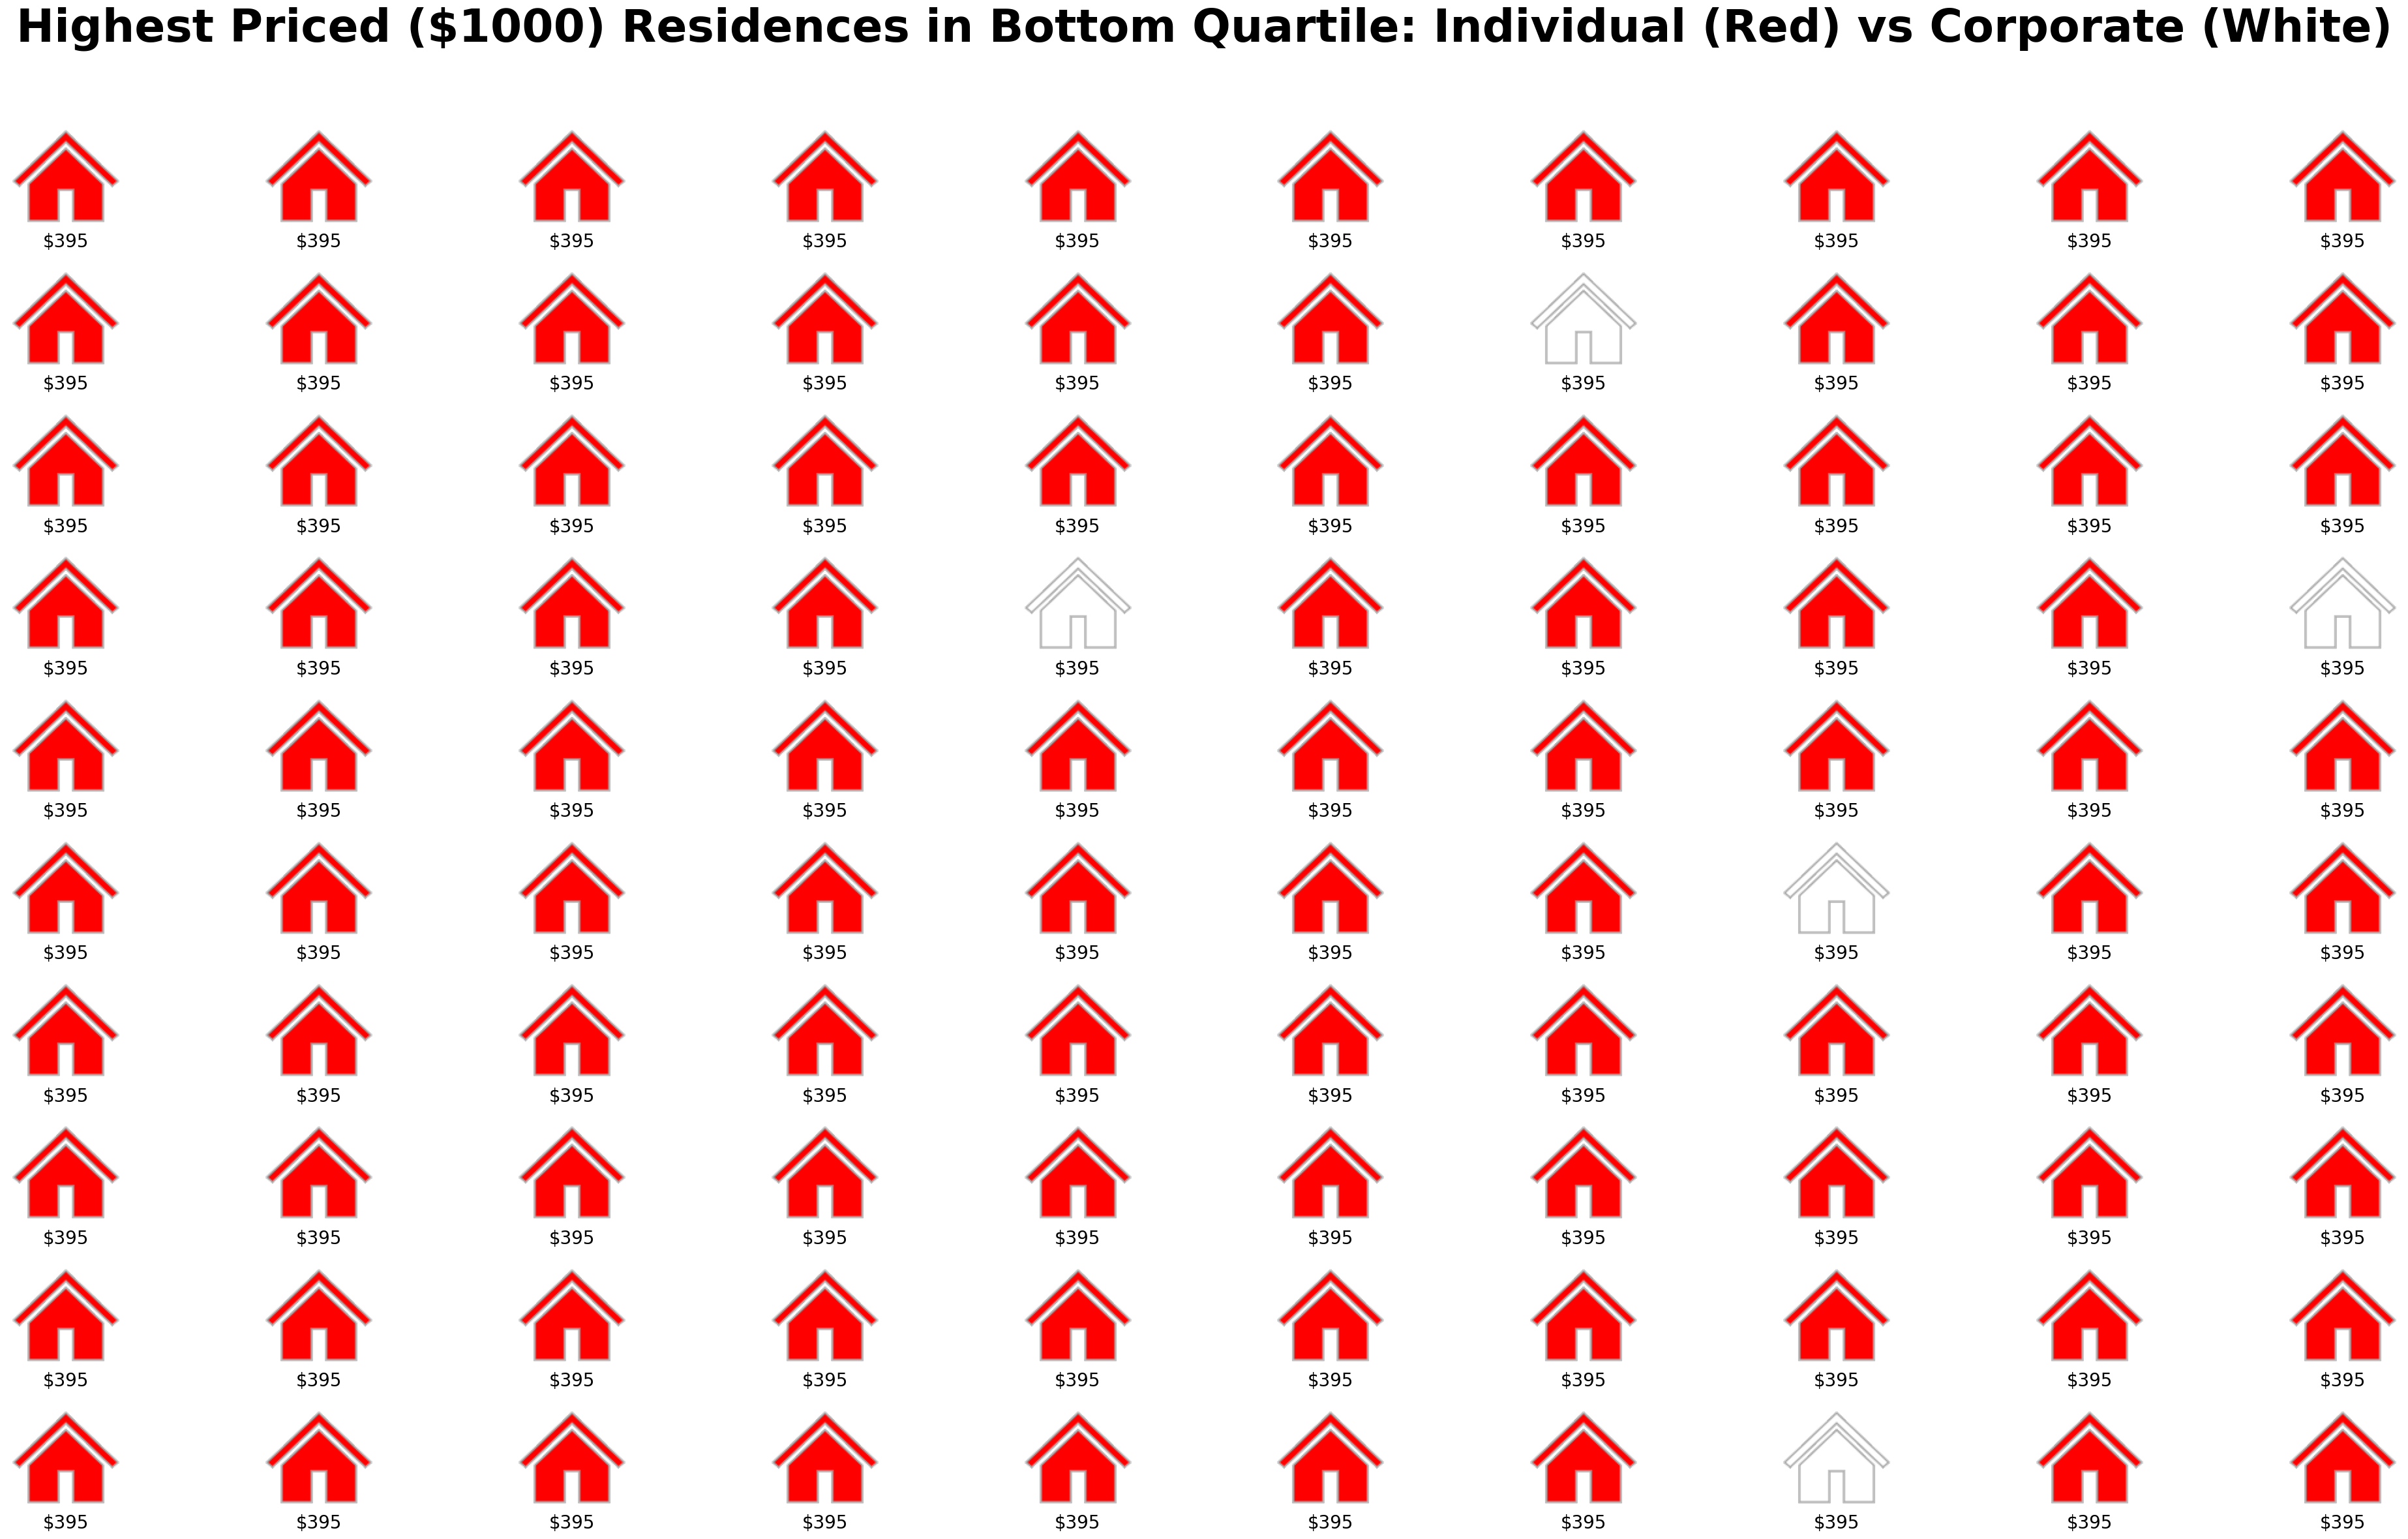

Percentage of corporate buyers among the selected bottom quartile Residential Purchases: 5.00%


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math

# -----------------------------
# 1. Load and prepare the data
# -----------------------------
data_path = 'Data/Residential sales data in the City of Boston, 2000-2023/A2_EDA_Residential.csv'
data = pd.read_csv(data_path)

# Convert the date column to datetime and create a year column if needed
data['date'] = pd.to_datetime(data['date'])
if 'year' not in data.columns:
    data['year'] = data['date'].dt.year

# -----------------------------
# 2. Select the highest priced residences within the bottom quartile
# -----------------------------
# Filter out commercial properties
non_commercial = data[data['proptype'] != 'COM']

# Calculate the 25th percentile for residential prices
bottom_quartile_threshold = non_commercial['price'].quantile(0.25)

# Filter for houses in the bottom quartile (prices at or below the 25th percentile)
bottom_quartile_houses = non_commercial[non_commercial['price'] <= bottom_quartile_threshold]

# We now sort these houses descending by price, then select top ones
num_houses = 100  # Adjust as needed
selected_houses = bottom_quartile_houses.sort_values('price', ascending=False).head(num_houses)

# -----------------------------
# 3. Define grid and image resources
# -----------------------------
n_cols = int(math.sqrt(num_houses))
if n_cols * n_cols < num_houses:
    n_cols += 1
n_rows = math.ceil(num_houses / n_cols)

# Image paths
full_house_img_path = 'FullHouse.png'
empty_house_img_path = 'EmptyHouse.png'

# -----------------------------
# 4. Create the figure and axes grid
# -----------------------------
fig, axes = plt.subplots(n_rows, n_cols, figsize=(40, 24))
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

# -----------------------------
# 5. Populate the grid with house images and labels
# -----------------------------
for idx, (i, row) in enumerate(selected_houses.iterrows()):
    ax = axes[idx]
    
    is_corporate = (row.get('buyer_bnk_ind', 0) == 1) or \
                   (row.get('buyer_bus_ind', 0) == 1) or \
                   (row.get('buyer_llc_ind', 0) == 1)
    
    image_path = empty_house_img_path if is_corporate else full_house_img_path
    
    try:
        img = mpimg.imread(image_path)
        ax.imshow(img)
    except FileNotFoundError:
        ax.add_patch(plt.Rectangle((0, 0), 1, 1, color='gray'))
        ax.text(0.5, 0.5, "Image\nNot Found", ha='center', va='center', color='white')
    
    # Display price below the image
    price = row['price']/1e+3
    ax.text(0.5, -0.1, f'${price:,.0f}', transform=ax.transAxes, fontsize=20, ha='center', color='black')
    
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# Turn off any unused axes.
for j in range(len(selected_houses), len(axes)):
    axes[j].axis('off')

plt.suptitle("Highest Priced ($1000) Residences in Bottom Quartile: Individual (Red) vs Corporate (White)", fontsize=50, fontweight='bold')
# add note under the title

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('bottom_houses.png', bbox_inches='tight')
plt.show()

# Print percentage of corporate buyers
corporate_buyers = selected_houses[selected_houses['buyer_llc_ind'] == 1]
percentage_corporate = len(corporate_buyers) / len(selected_houses) * 100
print(f"Percentage of corporate buyers among the selected bottom quartile Residential Purchases: {percentage_corporate:.2f}%")
